# Schelling's Segregation Model

Developed in the 1960s by economist Thomas Schelling, this model's primary purpose was to provide an explanation for the issue of residential segregation. It demonstrates how macro-level social patterns can emerge from the micro-level choices of the individual.

The mechanics of the model are simple:

1. The model consists of a fixed number of agents.
2. The environment is generally a 2D grid where only one agent can occupy a cell at a time.
3. Agents are randomly distributed across the grid. Each agent is a member of a group.
4. Each agent is given a tolerance threshold (τ) which represents the minimum percentage of same-group neighbors in the immediate vicinity.

## Notebook Goals

- Replicate the model.
- Visualize the grid change over time as agents move around.
- Experiment with different tolerance threshold values and simulation steps.

In [37]:
from enum import Enum
from mesa.agent import Agent
from mesa.model import Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
class Group(Enum):
    red = "red"
    blue = "blue"

class SegregatedAgent(Agent):
    """
    A simple agent which belongs to a group and will move around the grid to satisfy its tolerance_threshold.
    
    Attributes:
        group (Group): The group that this agent belongs to.
        tolerance_threshold (float): The minimum percentage of same-group neighbors in the agent's immediate neighborhood.
    """
    def __init__(self, model, group, tolerance_threshold = 0.5):
        super().__init__(model)
        self.group = group
        self.tolerance_threshold = tolerance_threshold
        
    def move(self):
        """
        Move the agent to an unoccupied neighboring cell.
        
        TODO: Prefer to move near members of the same group. 
        """
        # Get the cell coordinates around the current cell
        coords = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False,
        )
        
        # Filter down to only the empty cells
        empty_coords = [coord for coord in coords if self.model.grid.is_cell_empty(coord)]
        
        # If any empty coordinates are found, move to one randomly
        if empty_coords:
            self.model.grid.move_agent(
                self, 
                self.random.choice(empty_coords),
            )
            
    def step(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False,
        )
        
        if len(neighbors) == 0:
            # What to do if an agent is alone? Have them stay put or move
            # them around randomly?
            # TODO: Make this an option in the simulation.
            self.move()
            return
        
        neighborhood_group_percentage = len([n for n in neighbors if n.group == self.group]) / len(neighbors)
        
        # If the neighborhood group "score" is less the agent's tolerance level, move away.
        if neighborhood_group_percentage < self.tolerance_threshold:
            self.move()

In [39]:
class SchellingSegregationModel(Model):
    """
    A simple model showcasing society segregation from mild individual preferences.
    """
    def __init__(self, width=15, height=15, empty_grid_percent=0.5, seed=None, **kwargs):
        super().__init__(seed=seed)
        
        self.grid = MultiGrid(width, height, torus=False)
        self.num_agents = int(width * height - width * height * empty_grid_percent)
        self.datacollector = DataCollector(
            agent_reporters={"pos": "pos"},
            model_reporters={"grid_state": self.get_grid_state} ,
        )
        
        agents = []
        for i in range(self.num_agents):
            agents.append(SegregatedAgent(
                self,
                Group.red if i % 2 == 0 else Group.blue,
                tolerance_threshold=kwargs.get("agent_tolerance_threshold", 0.5),
            ))
            
        for agent in agents:
            self.grid.place_agent(agent, (0, 0))
            self.grid.move_to_empty(agent)
        
        self.datacollector.collect(self)
        
    def get_grid_state(self):
        """
        Creates a 2D numpy array representing the current state of the grid.
        """
        state = np.zeros((self.grid.width, self.grid.height))
        
        for cell in self.grid.coord_iter():
            agents, (x, y) = cell
            if agents:
                agent = agents[0]
                state[x][y] = 1 if agent.group == Group.red else -1
            else:
                state[x][y] = 0
                
        return state
                
    def step(self):
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

In [40]:
NUM_STEPS = 20
GRID_WIDTH = 50
GRID_HEIGHT = 50
PERCENT_EMPTY_GRID = 0.5
AGENT_TOLERANCE_THRESHOLD = 0.3
SEED = 51646

model = SchellingSegregationModel(GRID_WIDTH, GRID_HEIGHT, PERCENT_EMPTY_GRID, SEED, agent_tolerance_threshold=AGENT_TOLERANCE_THRESHOLD)
for i in range(NUM_STEPS):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

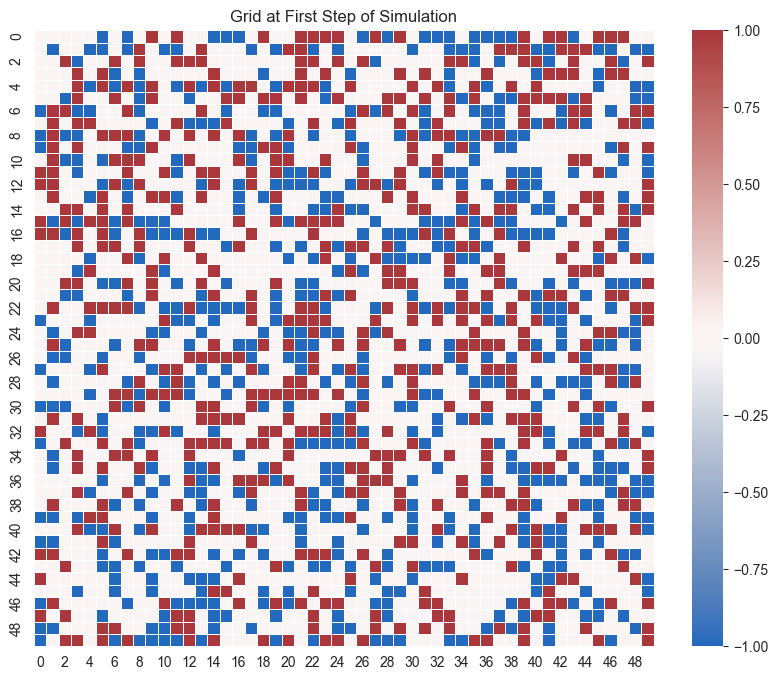

In [41]:
grid_state_data = model_data.iloc[0]["grid_state"]
plt.figure(figsize=(10, 8))
ax = sns.heatmap(grid_state_data, cmap=sns.color_palette("vlag", as_cmap=True), linewidths=.5)
ax.set_title(f"Grid at First Step of Simulation")
plt.show()
plt.close()

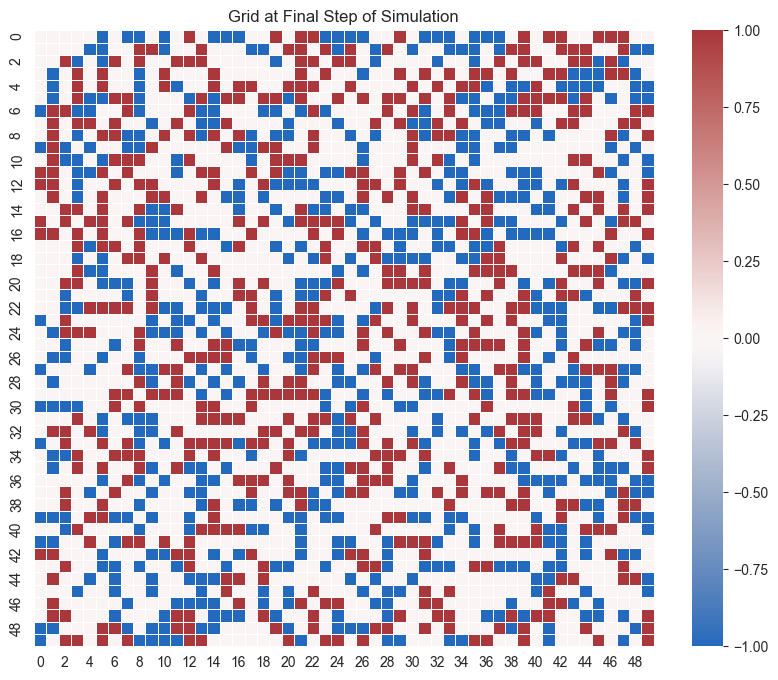

In [42]:
grid_state_data = model_data.iloc[NUM_STEPS]["grid_state"]
plt.figure(figsize=(10, 8))
ax = sns.heatmap(grid_state_data, cmap=sns.color_palette("vlag", as_cmap=True), linewidths=.5)
ax.set_title(f"Grid at Final Step of Simulation")
plt.show()
plt.close()

In [43]:
if True:
    import io, imageio
    with imageio.get_writer("g01_grid.gif", mode="I", fps=2) as writer:
        for step, row in model_data.iterrows():
            grid_state_data = row["grid_state"]
            plt.figure()
            ax = sns.heatmap(grid_state_data, cmap=sns.color_palette("vlag", as_cmap=True), linewidths=.5)
            ax.set_title(f"Grid at Step {step}")
            buffer = io.BytesIO()
            plt.savefig(buffer, format="png")
            buffer.seek(0)
            im = imageio.v2.imread(buffer, format="png")
            writer.append_data(im)
            plt.close()

![animated grid gif](g01_grid.gif)